In [4]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cloud_func_lib as cfl
import csv

In [18]:
def get_blqv(ds, blz_ind, t):
    '''
    Taking the mean up to the cloud base looks a little bit better, all the points are higher in the model. Vs, the whole BL, then it's better at the higher qv and worse at the low qv. 
    '''
    #return ds.q_vapour[t].where(ds.z<bl_z).mean().values*1000
    #return ds.q_vapour[t,:,:,:blz_ind].mean().values*1000
    return ds.q_vapour[t,:,:,:np.argmin(np.abs(ds.z.values - np.mean(ds.clbas.where(ds['clbas']!=0.0), axis=(1,2))[0].values))].mean().values*1000  # taking the average up to the cloud base. 
    
def get_blz(ppe_no, t):
    return np.loadtxt(f"/home/users/eers/sct/lwp_mask_csvs/sct_em{ppe_no}_inv_height.csv")[t]

# def get_deltatheta(ds, bl_z, t):
#     diff = ds.theta_mean[t, np.argmin(np.abs(ds.z.values - bl_z))]- ds.theta_mean[t, 1]
#     return diff.values

# def get_deltaqv(ds, bl_z, blqv, t):
#     return ds.q_vapour[t,:,:,np.argmin(np.abs(ds.z.values - bl_z))+5].mean(axis=(0,1)).values*1000 - blqv
#     return diff

def get_na(ds, t):
    return ds.q_accum_sol_number[t,:,:,1:].where(ds.z<500).mean().values*1e-6

def get_baut(ds):
    return float(ds.options_database[cfl.find_options(ds, b"b_aut")[0]].values[1])

def calc_diff_values(diff_dict, t, sim_type, i):
    ds = xr.open_dataset(f"/gws/nopw/j04/carisma/eers/sct/{sim_type}/{sim_type}{i}/sct_{sim_type}{i}_merged.nc")
    dt_subcloud_top, dt_blz_ind, diff_dict['dtheta'][1][i] = cfl.get_deltheta_thresh(ds, t)
    #dqv_subcloud_top, dqv_inv_ind, diff_dict['dqv'][1][i] = cfl.get_delqv_thresh(ds, t)
    diff_dict['dqv'][1][i] = (ds.vapour_mmr_mean[1,inv_ind+20]*1e3 - ds.vapour_mmr_mean[1,subcloud_top+20]*1e3).values
    diff_dict['bl_z'][1][i] = ds.zn[dt_blz_ind]
    diff_dict['blqv'][1][i] = ds.vapour_mmr_mean[t,5:dt_blz_ind].mean()*1e3
    #diff_dict['blqv'][1][i] = ds.vapour_mmr_mean[t,5:].where(ds.z<500).mean()*1e3
    diff_dict['na'][1][i] = get_na(ds, t) # get_na(ds, t) OR ds.q_accum_sol_number[t,:,:,1:dt_blz_ind].mean().values*1e-6
    diff_dict['baut'][1][i] = get_baut(ds)
    ds.close()
    return diff_dict

def plot_diff_values(diff_dict, t, sim_type, design, ax):
    for i in range(len(design)):
        if i not in [3, 11, 25, 35, 64, 81, 84]:
            diff_dict = calc_diff_values(diff_dict, t, sim_type, i)

            for j,(key,val) in enumerate(diff_dict.items()):
                p=ax[j].scatter(design[i][j], val[1][i])
                ax[j].plot(val[0], val[0], c='black')
                ax[j].set_title(key)
    return ax

NameError: name 'p' is not defined

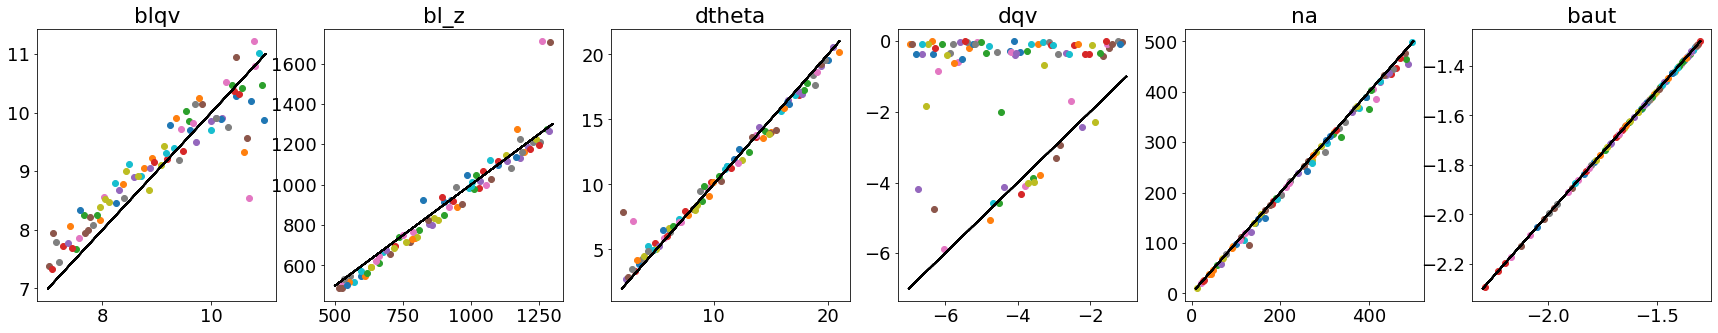

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=6,figsize=(30,5))

t = 1
sim_type='all'
if sim_type=='em':
    design = np.loadtxt("/home/users/eers/sct/lh_design/SCT_EmulatorInputsDesign.csv", skiprows=1, delimiter=',')
elif sim_type=='val':
    design = np.loadtxt("/home/users/eers/sct/lh_design/SCT_ValidationInputsDesign.csv", skiprows=1, delimiter=',')
elif sim_type=='all':
    em_design = np.loadtxt("/home/users/eers/sct/lh_design/SCT_EmulatorInputsDesign.csv", skiprows=1, delimiter=',')
    val_design = np.loadtxt("/home/users/eers/sct/lh_design/SCT_ValidationInputsDesign.csv", skiprows=1, delimiter=',')
    design = np.concatenate([em_design, val_design], axis=0)
    
#design = np.delete(design, [3, 11, 25, 35, 64, 81, 84], axis=0)
    
diff_dict = {'blqv': [(7, 11), np.empty((len(design)))], 'bl_z': [(500, 1300), np.empty((len(design)))], 'dtheta': [(2, 21), np.empty((len(design)))], 
             'dqv': [(-7, -1), np.empty((len(design)))], 'na': [(10, 500), np.empty((len(design)))], 'baut': [(-2.3, -1.3), np.empty((len(design)))]}

# for i in range(len(design)):
#     ds = xr.open_dataset(f"/gws/nopw/j04/carisma/eers/sct/{sim_type}/{sim_type}{i}/sct_{sim_type}{i}_merged.nc")

#     dt_subcloud_top, dt_blz_ind, diff_dict['dtheta'][1][i] = cfl.get_deltheta_thresh(ds, t)
#     dqv_subcloud_top, dqv_inv_ind, diff_dict['dqv'][1][i] = cfl.get_delqv_thresh(ds, t)
#     diff_dict['bl_z'][1][i] = ds.zn[dt_blz_ind]
#     diff_dict['blqv'][1][i] = ds.vapour_mmr_mean[t,5:dt_blz_ind].mean()*1e3
#     #diff_dict['blqv'][1][i] = ds.vapour_mmr_mean[t,5:].where(ds.z<500).mean()*1e3
#     diff_dict['na'][1][i] = get_na(ds, t) # get_na(ds, t) OR ds.q_accum_sol_number[t,:,:,1:dt_blz_ind].mean().values*1e-6
#     diff_dict['baut'][1][i] = get_baut(ds)

#     for j,(key,val) in enumerate(diff_dict.items()):
#         p=ax[j].scatter(design[i][j], val[1][i])
#         ax[j].plot(val[0], val[0], c='black')
#         ax[j].set_title(key)

#     ds.close()

ax=plot_diff_values(diff_dict, t, 'em', em_design, ax)
ax=plot_diff_values(diff_dict, t, 'val', val_design, ax)

for j,(key,val) in enumerate(diff_dict.items()):
    rmse = (np.mean(design[:,j] - val[1][:])**2)**0.5
    ax[j].legend([p],[f"rmse: {rmse:0.3}"])
    
ax[0].set_ylabel("After spin up")
fig.text(0.5,0.01,"LH Design")

In [9]:
fig.savefig("lh_design/post_spinupvalues/compare_spinup_thresholdvals_all.png")

In [11]:
# for key, val in diff_dict.items():
#     np.savetxt(f"post_spinupvalues/{key}_post_spinup.csv", val[1], delimiter=',')

post_cat=np.empty((len(design),6))
for i,v in enumerate(diff_dict.values()):
    post_cat[:,i]=v[1]
    
np.savetxt(f"lh_design/post_spinupvalues/val_post_spinup.csv", post_cat, delimiter=',')

### Plots showing the calculated subcloud top and transition top

In [4]:
ds = xr.open_dataset("/gws/nopw/j04/carisma/eers/sct/em/em0/sct_em0_merged.nc")
ds = cfl.ds_fix_dims(ds)

da = ds.theta_mean[0,5:]
da_q = ds.vapour_mmr_mean[0,5:]

m1 = min(da)
m2 = max(da)

q1 = min(da_q)
q2 = min(da_q)

In [8]:
heights=[]
qv_prof=[]
th_prof=[]
with open('master_ppe_input_csvs/string_master_array.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter='|')
    line_count=0
    for row in csv_reader:
        if line_count!=0:
            heights.append([float(i) for i in row[1].split(',')])
            th_prof.append([float(i) for i in row[2].split(',')])
            qv_prof.append([float(i)*1e3 for i in row[3].split(',')][:len(heights[line_count-1])])
        line_count+=1

Text(0.5, 0.98, 'Potential temp initial profiles')

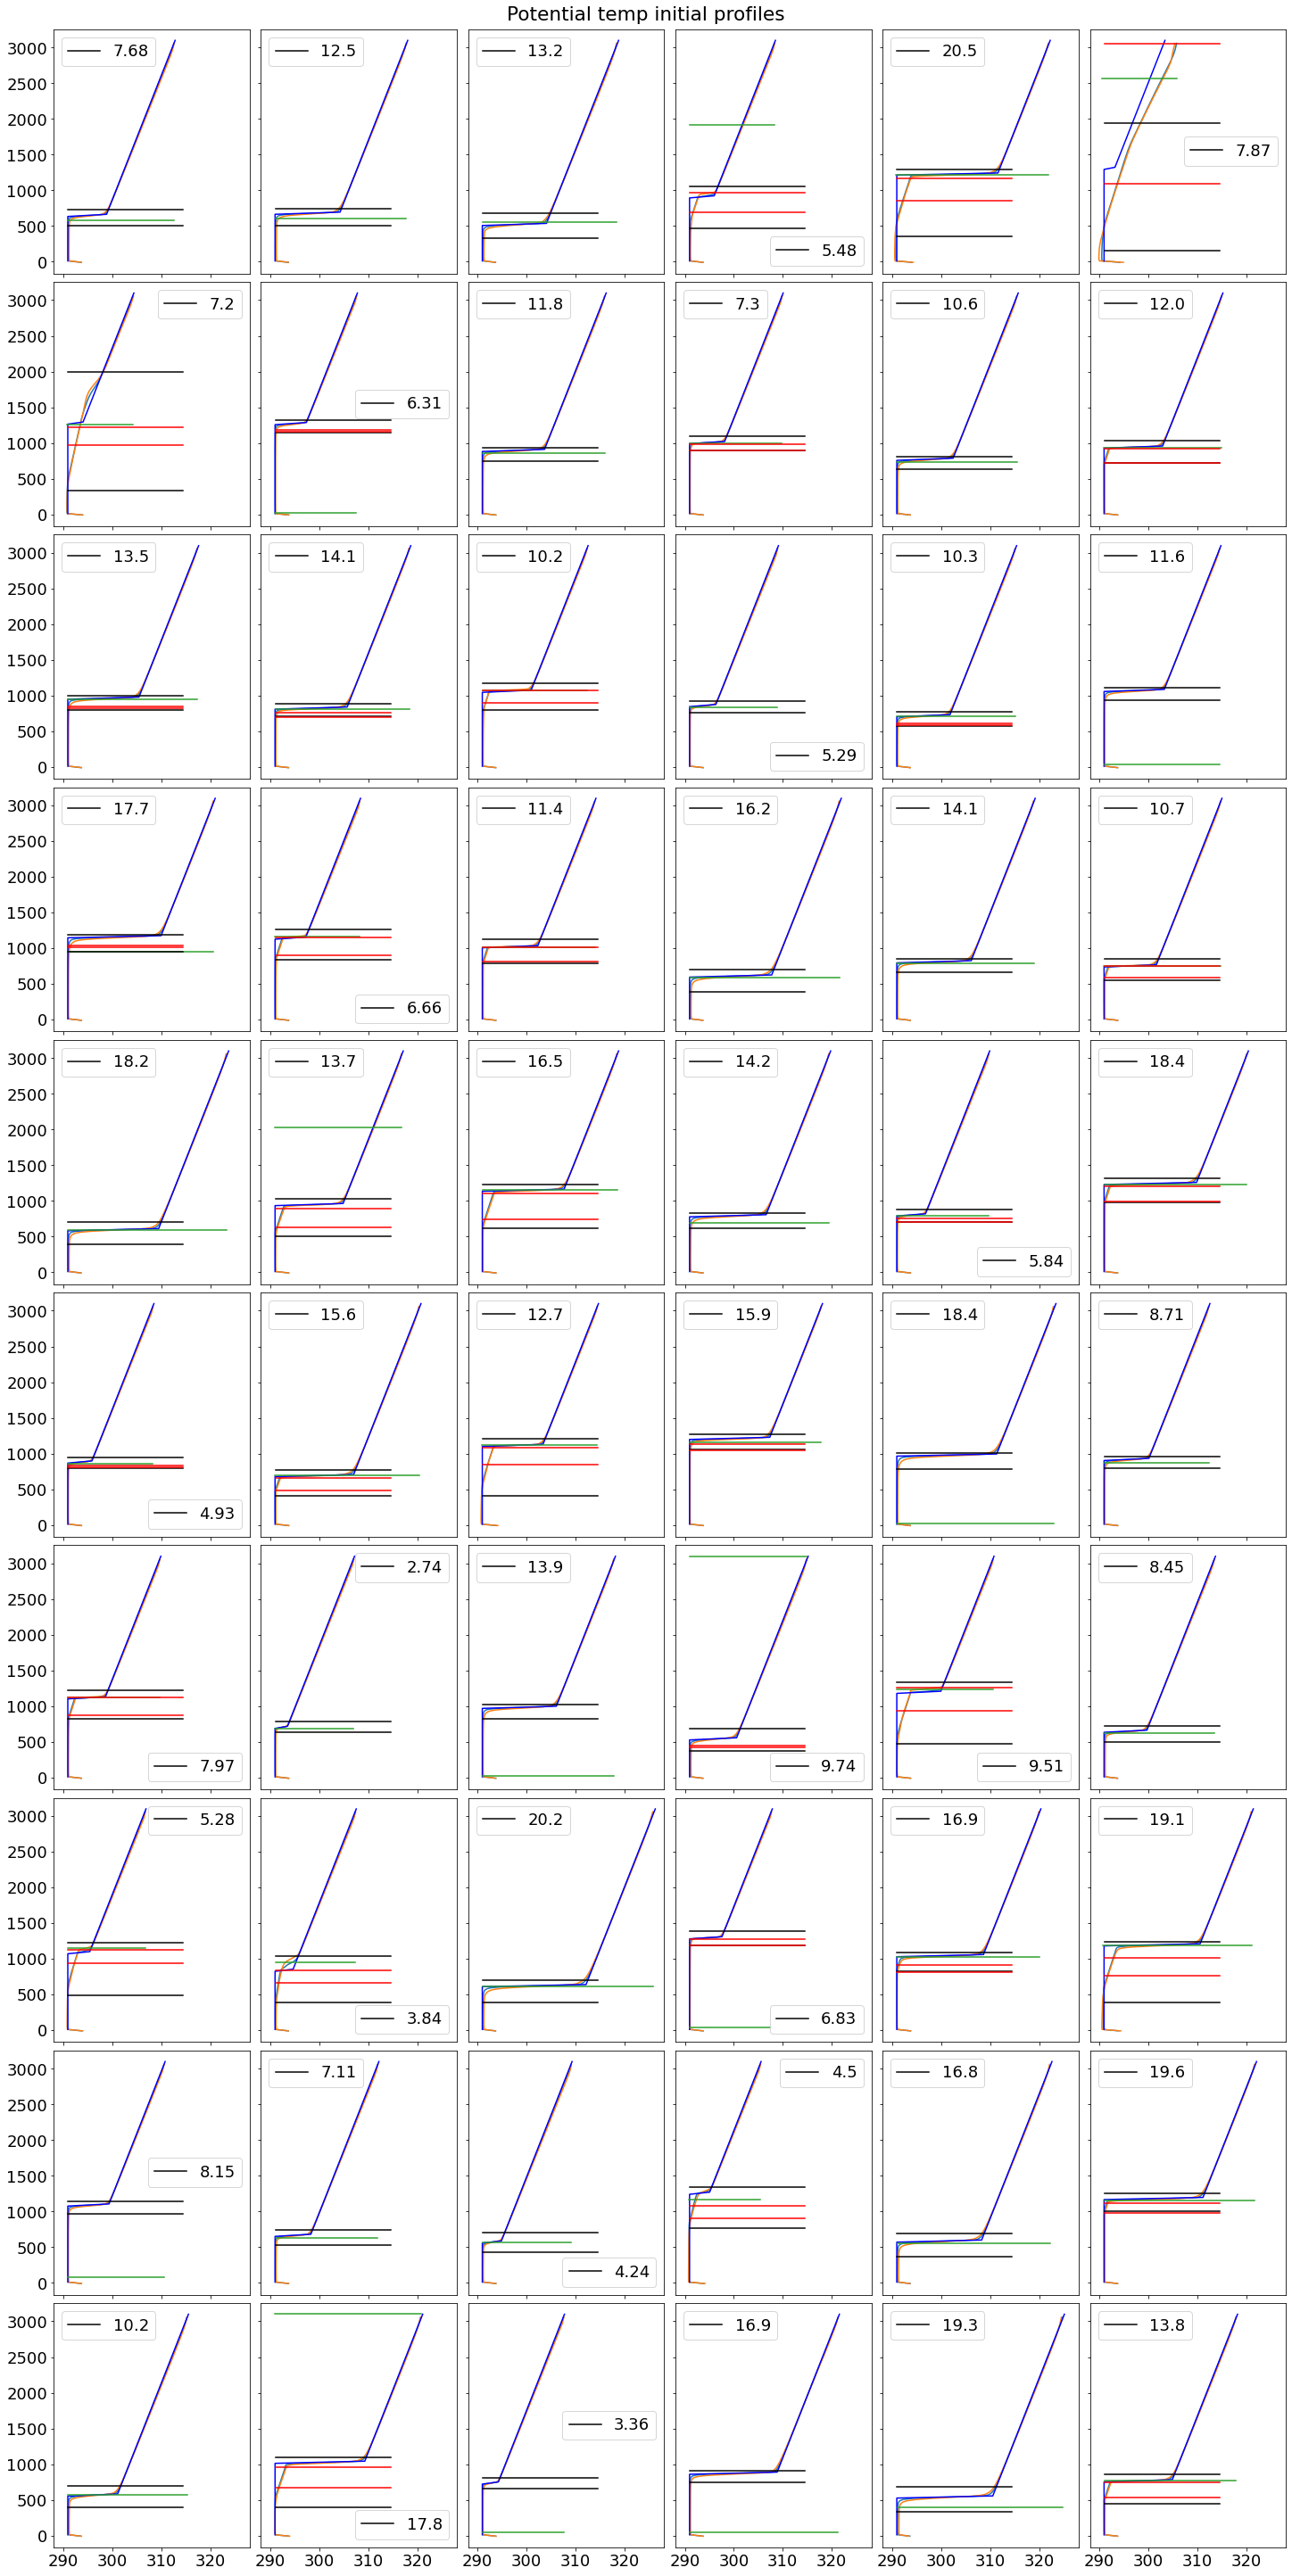

In [7]:
fig, ax = plt.subplots(nrows=10,ncols=6, figsize=(20,40), sharex=True, sharey=True, constrained_layout=True)

axes = []
for a in ax:
    for b in a:
        axes.append(b)
        
ind = 0
for a,b in zip(axes,range(1,61)):
    ds = xr.open_dataset(f'/gws/nopw/j04/carisma/eers/sct/em/em{b}/sct_em{b}_merged.nc')
    bl_z = get_blz(b, ind)
    blz_ind = np.argmin(np.abs(ds.z.values - bl_z))
    
    da=ds.theta_mean[1, 5:]
    ds.theta_mean[0].plot(y='zn', ax=a)
    ds.theta_mean[1].plot(y='zn', ax=a)
    a.plot(th_prof[b-1], heights[b-1], c='blue')
    a.plot((min(ds.theta_mean[ind]), max(ds.theta_mean[ind])), (bl_z, bl_z))

    subcloud_top, inv_ind, diff = cfl.get_deltheta_thresh(ds, 1)
    a.plot((m1, m2), (ds.zn[subcloud_top], ds.zn[subcloud_top]), c='black')
    l,=a.plot((m1, m2), (ds.zn[inv_ind+20], ds.zn[inv_ind+20]), c='black', label=f'{diff:0.3}')
    
    clbas_ave = np.mean(ds.clbas.where(ds['clbas']!=0.0), axis=(1,2))
    cltop_ave = np.mean(ds.cltop.where(ds['cltop']!=0.0), axis=(1,2))
    a.plot((m1, m2), (clbas_ave[1], clbas_ave[1]), c='red')
    a.plot((m1, m2), (cltop_ave[1], cltop_ave[1]),c='red')
    a.set_title('')
    a.set_ylabel('')
    a.set_xlabel('')
    a.legend()
    
#fig.text(0.5,0.01,"Potential temperature (K)", ha='center', va='center')
#fig.text(0.01,0.5,"Height (m)", ha='center', va='center', rotation=90)
fig.suptitle("Potential temp initial profiles")
#fig.savefig("pot_temp_profiles_inv_split_winitial.png")

-0.014700702907890939
-0.2308385572285192
-0.017145715200349798
-2.035452431511766
-6.641679295263923
-2.419951020401111
-4.964306594734706
-0.5207932874584449
-3.1439925411519773
-1.1382028401842321
-3.957192192702637
-4.228577586663626
-5.340522162939965
-1.2759472925368218
-6.038855801454152
-0.0961598915362476
-0.8691735923576562
-4.648799850779295
-3.1916729376021573
-1.9402917140033047
-4.793186253590319
-0.019637967129173095
-4.70362686932816
-4.490215808416929
-0.01952413591691826
-2.019904822544433
-2.6950315292797056
-2.958728110065251
-0.061801827199659876
-5.442939481832898
-0.04880304718166961
-4.608649756694312
-6.73081446438153
-6.287194290646446
-1.0636506823078546
-1.6980535291312489
-2.4049923787278127
-0.014608907571865615
-1.51443686855142
-0.015652611538872208
-5.613185962896437
-0.014705335716788337
-2.511267384761352
-4.016007908190368
-0.017885787518959972
-1.5030773851158319
-3.1664690235314588
-4.155385995527564
-0.5815681786111826
-0.015760108799650396
-0.014

Text(0.5, 0.98, 'Vapour mmr initial profiles')

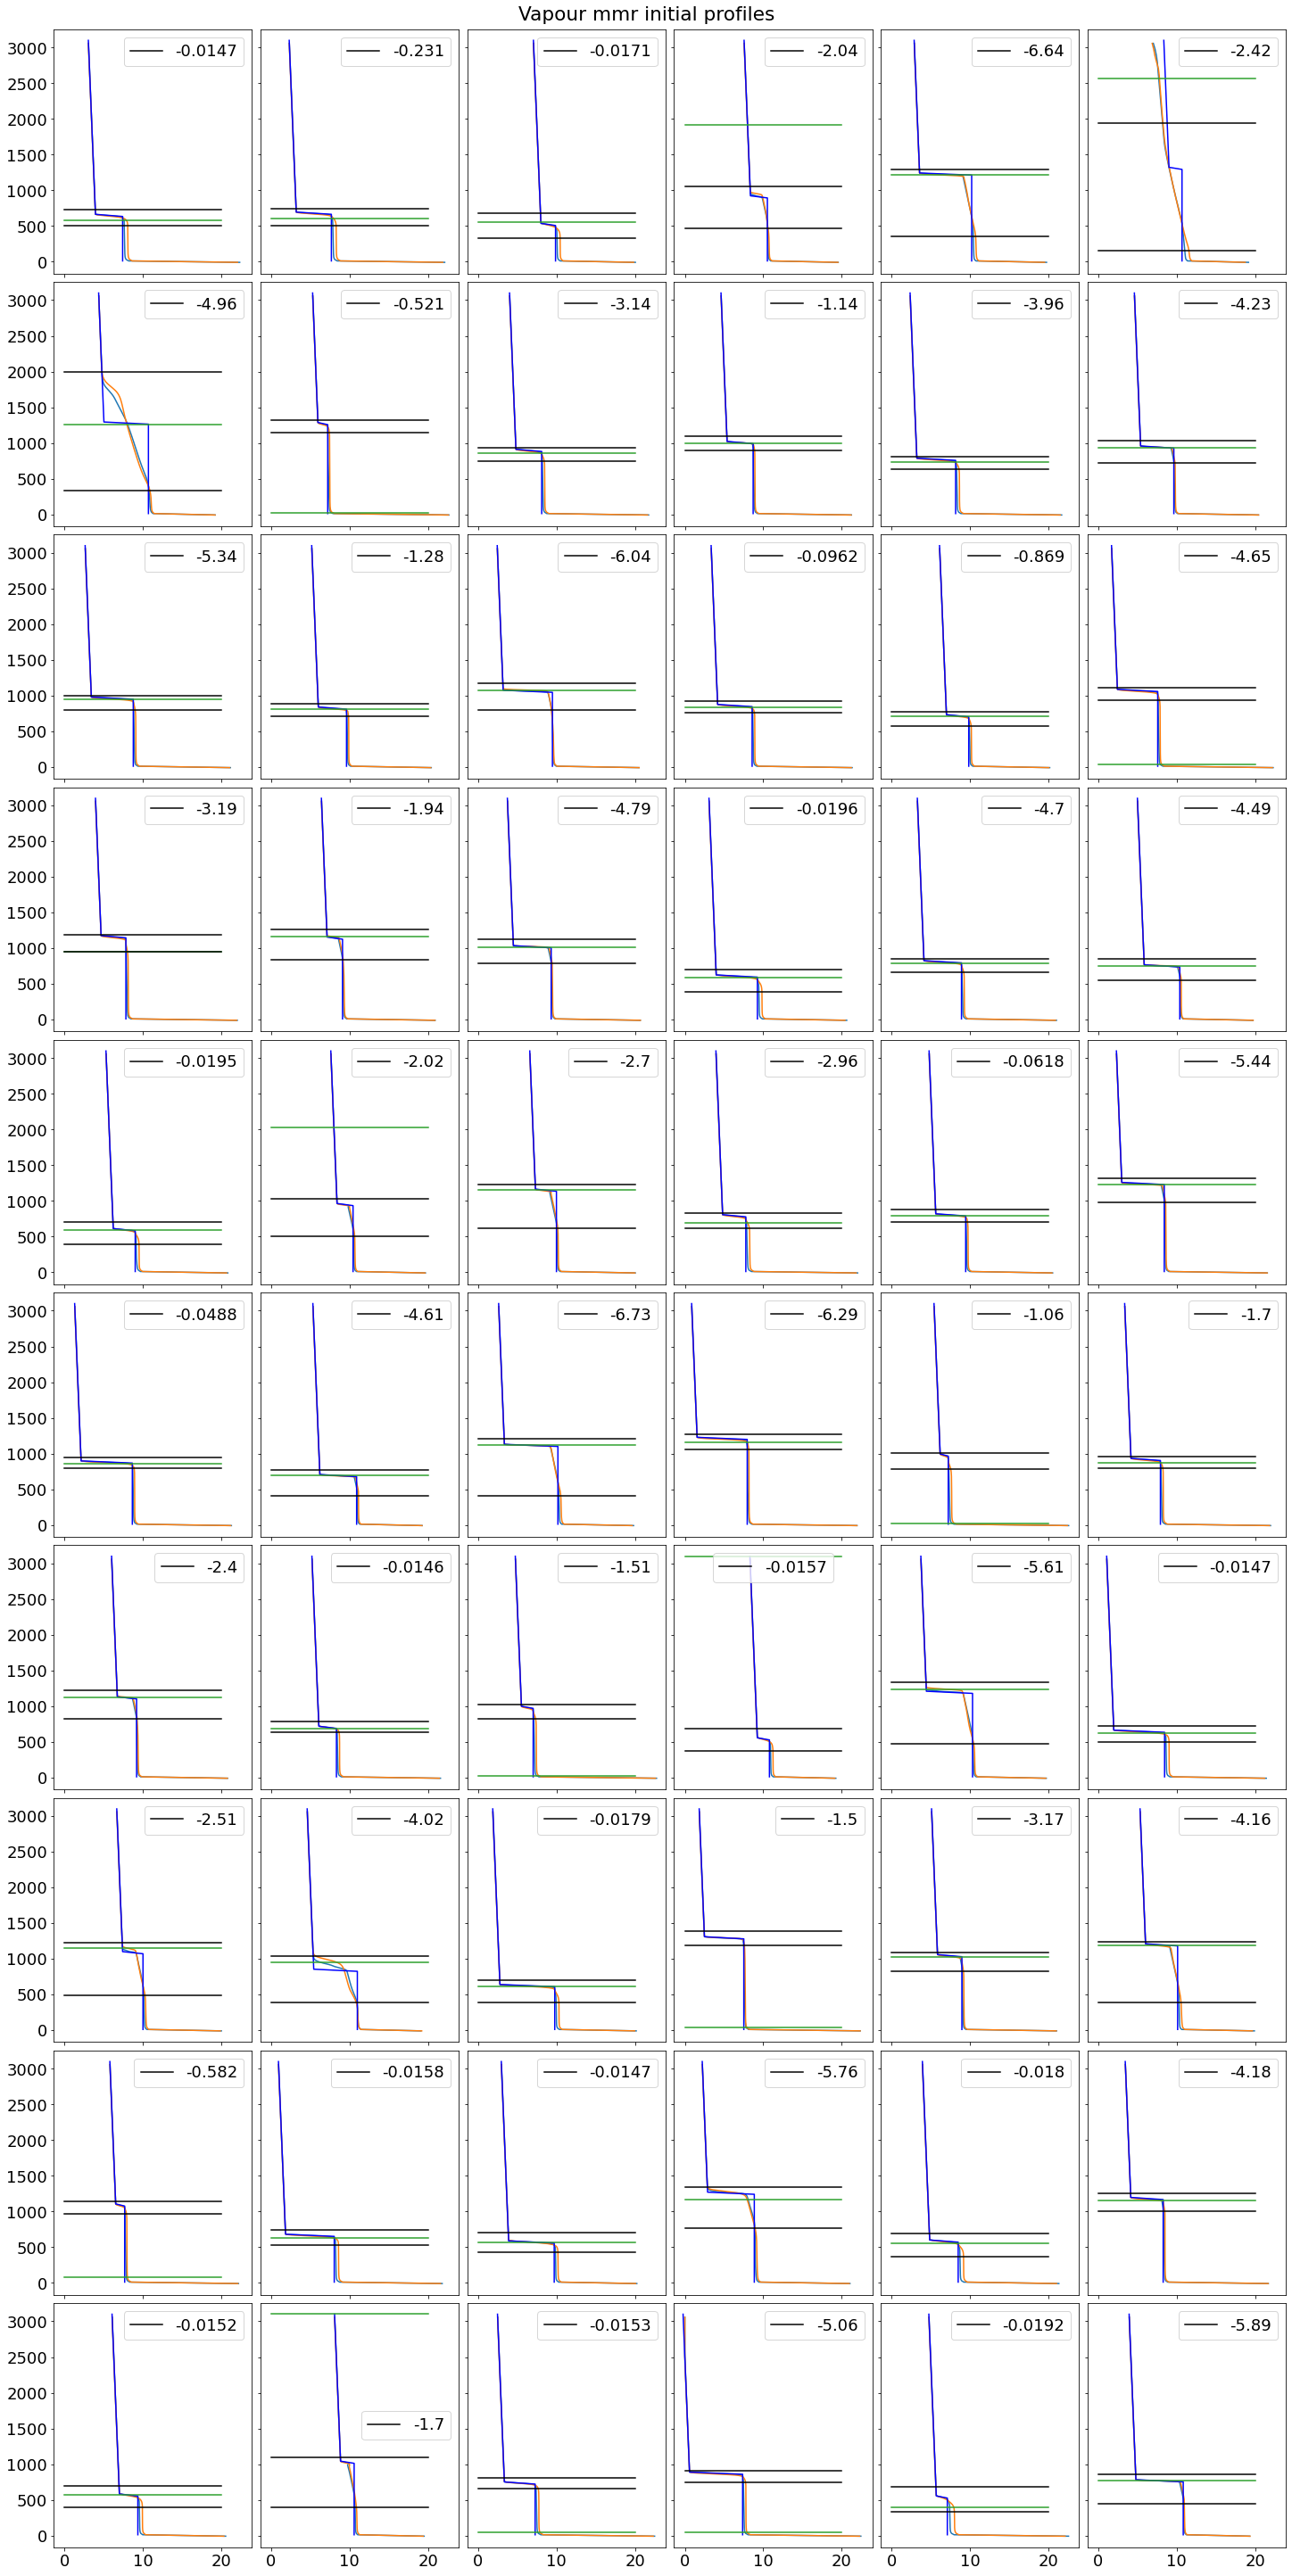

In [17]:
fig, ax = plt.subplots(nrows=10,ncols=6, figsize=(20,40), sharex=True, sharey=True, constrained_layout=True)

axes = []
for a in ax:
    for b in a:
        axes.append(b)

ind = 0
for a,b in zip(axes,range(1,61)):
    ds = xr.open_dataset(f'/gws/nopw/j04/carisma/eers/sct/em/em{b}/sct_em{b}_merged.nc')
    bl_z = get_blz(b, ind)
    blz_ind = np.argmin(np.abs(ds.z.values - bl_z))
    
    da_q = ds.vapour_mmr_mean[1,5:-2]*1e3
    zeroth=ds.vapour_mmr_mean[0]*1e3
    zeroth.plot(y='zn', ax=a)
    first=ds.vapour_mmr_mean[1]*1e3
    first.plot(y='zn', ax=a)
    a.plot(qv_prof[b-1], heights[b-1],c='blue')
    a.plot((0,20), (bl_z, bl_z))

    #subcloud_top, min_grad, diff = cfl.get_delqv_thresh(ds, 1)
    subcloud_top, inv_ind, diff = cfl.get_deltheta_thresh(ds, 1)
#     if min_grad < 240:
#         inv_ind = min_grad+20
#     else:
#         inv_ind = min_grad
    diff = (ds.vapour_mmr_mean[1,inv_ind+20]*1e3 - ds.vapour_mmr_mean[1,subcloud_top+20]*1e3).values
    a.plot((0,20), (ds.zn[subcloud_top], ds.zn[subcloud_top]), c='black')
    a.plot((0,20), (ds.zn[inv_ind+20], ds.zn[inv_ind+20]),c='black', label=f'{diff:0.3}')
    a.set_title('')
    a.set_xlabel('')
    a.set_ylabel('')
    a.legend()
    
#fig.text(0.5,0.01,"Vapour mmr (g/kg)", ha='center', va='center')
#fig.text(0.01,0.5,"Height (m)", ha='center', va='center', rotation=90)
fig.suptitle("Vapour mmr initial profiles")
#fig.savefig("vap_mmr_profiles_inv_split_winitial.png")